# 2.155/6 Optimization Demo
### In this demo we will demonstrate the use of both gradient-based optimization and evolutionary optimization on a linkage design problem. This notebook also serves as an introduction to the Challenge Problem 1, which will tackle a more complex linkage design problem.


><small>License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).</small>

## Optimization: A Quick Recap
In optimization our objective is to find the best possible solution for a given objective function. Often, however we also have some constraints that we might want to meet as well. More concretelty in general an optimization problem has three main components:

- **Design Variables**, $\mathbf x$: A set of design variables, describing the parmeters of the underlying problem. For example, imagine you are designing a bike like the ones in the visualization demo, then the design variables would be all those variables we saw describing a bike!
- **Objective Function:**, $f(\mathbf x)$: A function of the design variables that provides a measure of performance. Our aim to find the best $mathbf x$ that either minimizes this function or maximizes it. For example we may want the lightest possible bike. We would have to find the best possible $x$ that minimizes the weight of the box.
- **Constraints**, $\Omega$: Constraints are described as a set, dennoted as $\Omega$ here, which the design variables must be inside to be considered valid. For example, in our example of minimizing the bike weight, we can just set all parmeters to 0 and deliver air 🙃, with no weight, but that would not be a bike. The point of having constraints is to find the best possible $mathbf x \in \Omega$ which results in a valid design, not just the design that optimized $f(\mathbf x)$. Note that the set $\Omega$ in many cases is describved as a set of inequality and equality constraints on functions of $\mathbf x$, for example $g(\mathbf x)\leq0,\;h(\mathbf x)=0,\; l\leq\mathbf x\leq u,\; \ldots$


Often we use the following mathematical notation to describe optimization problems:

$$
\begin{align}
    \min_{\mathbf x} &f(\mathbf x)\\
    \text{subject to}\quad & l\leq \mathbf x \leq u\\
    &h(\mathbf x)=0\\
    &g(\mathbf x)\leq0\\
    &\ldots
\end{align}
$$

More compactly:

$$
\begin{align}
    \min_{\mathbf x} &f(\mathbf x)\\
    \text{subject to}\quad & \mathbf x \in \Omega
\end{align}
$$

We talked about a few different ways of how optimization can be done in practice. In this notebook we will demonstrate two approaches for optimization. First we will walk through a **gradient based optimization** approach, then we will follow that up with an application of the **genetic algorithm**.

## Let's Optimize Some Mechanisms

<div width="100%"><img src="https://i.imgur.com/69xDuZc.png" alt="Path Synthesis Problem" width="60%" style="margin:auto;display:block"></div>

In this demonstration, we will focus on a specific problem we are solving, called the linkage synthesis problem. The goal in this problem is to design a linkage mechanism that can trace a target curve. If you remember we tried to do this manually in the first lecture for a simple case. To solve this problem we need to answer some questions: how many joint do we need?, how many linkages? which joints are linkages connecting? Which joints are fixed in space? and what are the initial posisitions of the joints(i.e. how long are the linkages)? 

Besides the questions above we need to make sure the mechanisms can move with only one actuator, and that the actuator can make a full rotation and does not get stuck at any point.

Going back to the optimization components we have:

- **Design Variables**, $\mathbf x$: Number of joints, the types of joints (fixed or not), number of linkages, which joints linkages connect, initial positions of joints in space.
- **Objective Function:**, $f(\mathbf x)$: How closely the curve traced by the mechanism resembles the target curve.
- **Constraints**, $\Omega$: The mechanism must one degree of freedom (can be run by a single motor), the mechanism cannot lock during a full rotation of the actuator.

**But how do we handle these computationally and in code?**

### Representing Mechanisms
In practice the optimization problem of path synthesis is quite complicated. Here we will briefly discuss how we can represent linkage mechanisms. In this demonstration we will represent linkage mechanisms as graphs. A graph is represented as a set of nodes (e.g., $N = \{1,2,3,\ldots,N\}$), and set of edges, that describe how nodes are connected to each other (e.g., $E=\{(1,2), (5,2), \ldots \}$). Graphs can also include features associated with each node (e.g., initial positions of joints in our example of mechanisms).

To see how this works take the mechanism below:

<div width="100%"><img src="https://i.ibb.co/qsPC0gC/2021-09-13-0hl-Kleki.png" alt="Path Synthesis Problem" width="40%" style="margin:auto;display:block"></div>


We can see that we have 5 joints, which we will represent as 5 node, $N=\{0,1,2,3,4\}$, and we can represent the linkages as edges in the graph, which give us the edges $E=\{(0,2),(1,3),(2,3),(2,4),(3,4)\}$. Note that edges in this graph do not have directions so $(0,2)$ and $(2,0)$ are identical we just like to keep things neat so we always left the smaller index first. Besides the basic graph describing the mechanisms structure, we also see that nodes $0$ and $1$ are fixed and the nodes are placed in 2D space in a certain way. We will describe these as node features. This means each node will have a 2D initial position and a binary feature describing whether it is fixed or not. We can also see that one of the linkages is highlighed yellow. This is the linkage that is rotated by the actuator. We will also store this information.

In practice the above description boils down to a few (Design) variables in python which we use to describe the mechanism:

- **Initial Positions** `x0`: A 2D array of size $N \times 2$, holding the initial positions of the $N$ joints in the mechanism.
- **Linkages** `edges`: A 2D array of ***integer*** pairs, with shape $E \times 2$ holding the pairs of node indecies from two nodes that are connected to each other by an edge.
- **Fixed Joints** `fixed_joints`: A list of node indicies that are fixed.
- **Motoe** `motor`: A tuple of integers, which is equivalent to the pair of node indicies associated with the actuated edge.

So let's try to describe the mechanism in the image above in Python and see how this works:

In [1]:
# import some modules we will need
import os
os.environ["JAX_PLATFORMS"] = "cpu"  # Disable GPU for JAX
import jax
import numpy as np
import matplotlib.pyplot as plt
from LINKS.Geometry import CurveEngine

# We provide some useful functions and classes for handling linkage mechanisms
from LINKS.Visualization import MechanismVisualizer
from LINKS.Kinematics import MechanismSolver
from LINKS.Optimizer._OptimTools import build_optimization_functions, build_material_optimization_functions, build_scaled_optimization_functions
from tqdm.auto import tqdm, trange

Now let's define our mechanism and make an instance of the visualizer we have provided you:

In [2]:
# make an instance of the visualizer
visualizer = MechanismVisualizer()

# Define the variables for the mechanism
x0 = np.array([[0.3,0.2],
               [0.6,0.2],
               [0.3,0.3],
               [0.6,0.4],
               [0.4,0.5]])

# Define the connectivity of the mechanism
edges = np.array([[0,2],
                  [1,3],
                  [2,3],
                  [2,4],
                  [3,4]])

# Define the fixed nodes
fixed_joints = np.array([0,1])

# actuator
motor = np.array([0,2])

Now we can visualize this mechanism:

<Axes: >

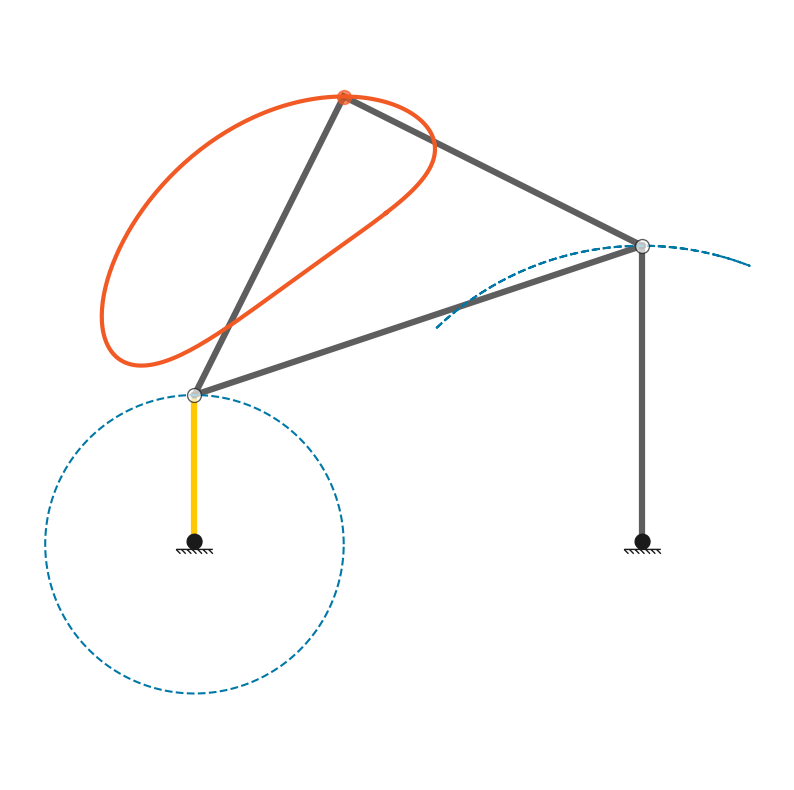

In [7]:
visualizer(x0, edges, fixed_joints, motor)

### The Objective Function
Now that we have figured out the design variables, we will move on to the objective function. The objective here is to match a target curve. Comparing two curves is it's own can of worms and involves a whole bunch of theory and geometry. For now we will provide function that take care of aligning curves and measuring the difference between two curves. 

Our goal is to optimize a mechanism to produce the curve we have provided below:

(np.float64(-0.9539660900831223),
 np.float64(1.0731105893850326),
 np.float64(-1.2513642966747285),
 np.float64(1.1959728658199311))

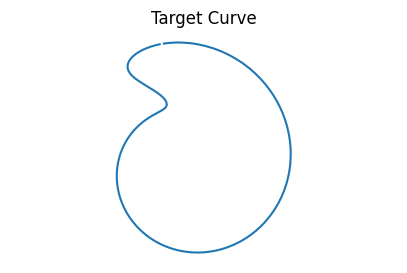

In [8]:
# load the target curve
target_curve = np.load('SampleCurves/samples.npy')[37]

plt.figure(figsize=(5,3))
plt.plot(target_curve[:,0], target_curve[:,1])
plt.title('Target Curve')
plt.axis('equal')
plt.axis('off')

Now let's see how well the curve produced by our mechanism matches this curve:

In [9]:
 #make an  instance of the solver to get the mechanims curves
solver = MechanismSolver()

(np.float64(0.22673571184277536),
 np.float64(0.4723212860524654),
 np.float64(0.31068813502788545),
 np.float64(0.5090121656656266))

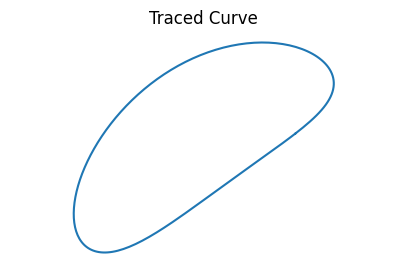

In [10]:
# solve and get the coupler curve from node 4
curve = solver(x0, edges, fixed_joints, motor)[-1]

plt.figure(figsize=(5,3))
plt.plot(curve[:,0], curve[:,1])
plt.title('Traced Curve')
plt.axis('equal')
plt.axis('off')

These two curves are not aligned with each other properly. So we first have to align them to be able to measure their difference. We provide a function called `align` which does this.

In [11]:
# make an instance of the CurveEngine
geomety_engine = CurveEngine(resolution=200, equisample=True, normalize_scale=True, device='cpu')

In [13]:
# align and measure the distance between the two curves
# aligned_curve, aligned_target_curve, distance = align(curve, target_curve)
aligned_curve, aligned_target_curve, distance = geomety_engine.optimal_alignment(curve, target_curve)

print(f'Distance between curves: {distance:.4f}')

Distance between curves: 1.4997


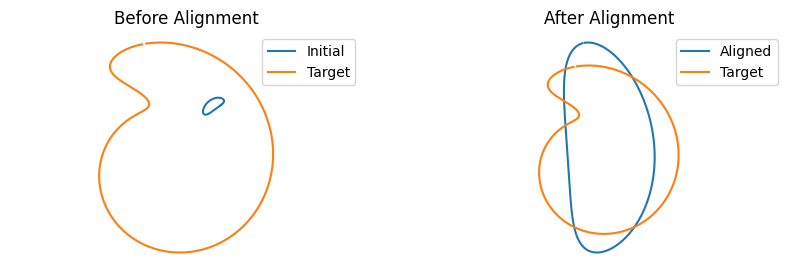

In [14]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(curve[:,0], curve[:,1], label='Initial')
plt.plot(target_curve[:,0], target_curve[:,1], label='Target')
plt.title('Before Alignment')
plt.axis('equal')
plt.axis('off')
plt.legend()

plt.subplot(1,2,2)
plt.plot(aligned_curve[:,0], aligned_curve[:,1], label='Aligned')
plt.plot(aligned_target_curve[:,0], aligned_target_curve[:,1], label='Target')
plt.title('After Alignment')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()

## Gradient-Based Optimization
Now that we have the basics of the problem figured out let's actually do some optimization. To keep things simple in this demo we will not try to generate whole mechanisms. Instead we will just use the mechanism we defined above and only optimize the initial positions of the joints.

To do this we provide a function to create a function that returns both the difference between curves and the gradient of the initial positions with respect to this distance. This function is conviniently called `build_optimization_functions`. It returns a function which takes initial positions and gives us the value of the objective function and the gradients of the objective with respect to theses positions.

In [ ]:
obj_and_grad = build_optimization_functions(
    x0,
    edges,
    fixed_joints,
    motor,
    target_curve
)

Now let's run this function with our current initial posisions and see what the output is like:

In [ ]:
objective, gradients = obj_and_grad(x0)

print(f'Objective: {objective:.4f}')
print(f'Gradients:\n{gradients}')

Now we can just perform a simple gradient decent for this mechanism until either convergence or until we see the mechanism lock. If the optimization takes a step that leads to a locking mechanism the objective function will become inifinity and we will stop the optimization loop:

In [ ]:
# set the optimization parameters
step_size = 1e-4
max_iters = 200

x = x0.copy()
objective_history = []
x_history = []

progress_bar = trange(max_iters)
for step in progress_bar:
    objective, gradients = obj_and_grad(x)
    
    if np.isinf(objective) or np.any(np.isnan(gradients)):
        print('Mechanism locked. Stopping optimization.')
        x = x_history[-1]
        x_history.pop()
        objective_history.pop()
        break
    
    objective_history.append(objective)
    x_history.append(x.copy())
    
    x -= step_size * gradients

    progress_bar.set_postfix({'Objective': objective})

We see that the objective function is much smaller at the end of this optimization. Let's visualize the mechanism and compare the curves:

In [ ]:
# animate the evolution of the mechanism
from matplotlib import animation
from IPython.display import HTML

# animate the evolution of the mechanism
fig, ax = plt.subplots(figsize=(5,5))
ax.axis('equal')
ax.axis('off')

def update(frame):
    ax.clear()
    ax.axis('equal')
    ax.axis('off')
    visualizer(x_history[frame], edges, fixed_joints, motor, ax=ax)
    ax.set_title(f'Iteration {frame+1}/{len(x_history)}, Objective: {objective_history[frame]:.4f}')

ani = animation.FuncAnimation(fig, update, frames=len(x_history), interval=200)
plt.close(fig)
HTML(ani.to_jshtml(fps=25, default_mode='once'))

Now let's plot how the objective function changed with optimization:

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(objective_history)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective Function (log scale)')
plt.title('Objective Function History')
plt.grid()
plt.show()

In [ ]:
initial_curve = solver(x0, edges, fixed_joints, motor)[-1]
optimized_curve = solver(x, edges, fixed_joints, motor)[-1]

aligned_curve, aligned_target_curve, distance = align(curve, target_curve)
aligned_optimized_curve, aligned_target_curve_optimiz, optimized_distance = align(optimized_curve, target_curve)

print(f'Initial Distance between curves: {distance:.4f}')
print(f'Optimized Distance between curves: {optimized_distance:.4f}')

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(aligned_curve[:,0], aligned_curve[:,1], label='Initial')
plt.plot(aligned_target_curve[:,0], aligned_target_curve[:,1], label='Target')
plt.title('Before Optimization')
plt.axis('equal')
plt.axis('off')
plt.legend()

plt.subplot(1,2,2)
plt.plot(aligned_optimized_curve[:,0], aligned_optimized_curve[:,1], label='Optimized')
plt.plot(aligned_target_curve_optimiz[:,0], aligned_target_curve_optimiz[:,1], label='Target')
plt.title('After Optimization')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()

We can see that the curves are more similar to each other after optimization but this is a hard problem and from that starting point this is where the optimization takes us.

## Genetic Algorithm
We saw how if we have a starting point for our mechanism we can run a local gradient based optimization to try to match our target curve. But what if we did not know what initial point is better. Also what if we have multiple objectives. Another approach for optimization we discussed in class was genetic algorithms. In this part of the demo we will run the NSGA-II algorithm for the same problem with an added objective. We will now also try to minimize the total material used in the linkage mechanism. That is we want to use the least possible amount of material (total length of linkages) while also matching our target curve.

### Single Objective Case
First let's just do what we did with gradient-based optimization using GA.

We will use the pymoo implementation of the NSGA-II algorithm. To use pymoo we must first define the problem within pymoo. There are several things to note about this problem. First, we have to set the number of parameters which in this case are the $x,y$ positions of the 5 nodes (2x5=10 parameters). The other part of the problem is the number of objectives. In this first case we just have to look at the distance between the traced curve and the target so we have only on objective. The last thing is to set the lower and upper bound for the parameters, which will be 0.0 and 2.0 respectively.

In [ ]:
# pymoo imports
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

First we define the problem in pymoo:

In [ ]:
class mechanism_optimization(ElementwiseProblem):

    # When intializing get the mechanism structure which is being optimized
    #(not the initial positions as we are trying to find those)
    def __init__(self, x0, edges, fixed_joints, motor, target_curve):

        # set the problem paramters(n_var = number of parameters(number of nodes * 2),
        # n_obj=number of objectives, xl=lower bound for the parameters, xu=upper bound for the paramters)
        super().__init__(n_var = x0.shape[0] * 2, n_obj=1, xl=0.0, xu=2.0, elementwise_evaluation=True)

        # Store mechanism information for later
        self.x0 = x0
        self.edges = edges
        self.fixed_joints = fixed_joints
        self.motor = motor
        self.N = x0.shape[0]

        # Store the target curve point cloud
        self.tpc = target_curve
        
        # setup the evaluation function
        self.obj_and_grad = build_optimization_functions(
            self.x0,
            self.edges,
            self.fixed_joints,
            self.motor,
            self.tpc
        )


    def _evaluate(self, x, out, *args, **kwargs):
        x0 = np.array(x.reshape([self.N,2]))  #reshape the flattened vector that comes in into 2D array
        
        # Simulate
        obj, grad = self.obj_and_grad(x0)
        out["F"] = obj

Now we will setup the parameters for NSGA-II:

In [ ]:
# Setup an instance of our problem
problem = mechanism_optimization(x0, edges, fixed_joints, motor, target_curve)

# Setup the algorithm
algorithm = NSGA2(pop_size=32,
                  sampling=FloatRandomSampling(),
                  crossover=SBX(prob=1.0, eta=3.0),
                  mutation=PolynomialMutation(eta=3.0, prob=0.05),
                  eliminate_duplicates=True)

Now let's run NSGA-II:

In [ ]:
results = minimize(problem,
                   algorithm,
                   ('n_gen', 50),
                   verbose=True,
                   save_history=True,
                   seed=3)

We will now visualize the populations in each generation by only displaying the the nodes in different colors:

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
def animate(i):
    plt.clf()
    population = results.history[i].pop.get("X")
    for m in population:
        inits = np.reshape(m,[-1,2])
        plt.scatter(inits[:,0],inits[:,1])
    plt.axis('equal')
    plt.title(f'Generation {i+1}/{len(results.history)}')


ani = animation.FuncAnimation(fig, animate, frames=50)

HTML(ani.to_jshtml(fps=5, default_mode='once'))

Note that the population is initially diverse and as the genetic algorithm progresses the population becomes more and more uniform and at the end it is almost all the same. This is typical in algorithms with high selectivity of superior performing memebers of the population.

Now let's grab the best solution found and visualize it:

In [ ]:
if results.X.ndim >1:
    best_x0 = results.X[0].reshape(-1,2)
else:
    best_x0 = results.X.reshape(-1,2)

In [ ]:
visualizer(best_x0, edges, fixed_joints, motor)

In [ ]:
initial_curve = solver(x0, edges, fixed_joints, motor)[-1]
optimized_curve = solver(best_x0, edges, fixed_joints, motor)[-1]

aligned_curve, aligned_target_curve, distance = align(curve, target_curve)
aligned_optimized_curve, aligned_target_curve_optimiz, optimized_distance = align(optimized_curve, target_curve)

print(f'Initial Distance between curves: {distance:.4f}')
print(f'Optimized Distance between curves: {optimized_distance:.4f}')

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(aligned_curve[:,0], aligned_curve[:,1], label='Initial')
plt.plot(aligned_target_curve[:,0], aligned_target_curve[:,1], label='Target')
plt.title('Before Optimization')
plt.axis('equal')
plt.axis('off')
plt.legend()

plt.subplot(1,2,2)
plt.plot(aligned_optimized_curve[:,0], aligned_optimized_curve[:,1], label='Optimized')
plt.plot(aligned_target_curve_optimiz[:,0], aligned_target_curve_optimiz[:,1], label='Target')
plt.title('After Optimization')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()

We see that because genetic algorithm mutates the mechanism and randomly changes the configuration it can get out of a local feasible region and find a better feasible solution.

**Reflection 1: Start gradient based optimization from the solution the GA provided. Does gradient-based optimization improve the GA solution? If so by how much? [write your code below and explain what the code is doing exactly] (30s)**

NOTE: You must be able to acheive an objective value of atleast 0.18. You will have to make some changes to the original gradient decent to do this.

In [ ]:
## YOUR CODE HERE
## HINT: Use the code we gave you for gradient based optimization and start from best_x0. Adjust step size and number of iterations and see what happens.


### Multi-Objective Case
Now let's incorporate the material requirements into the problem and final optimal solutions that balance the two objectives. We will do the same thing as before, except now we will have two objective functions. For the material objective function we provide a function called `build_material_optimization_functions`, which will make a function similar to the one for comparing curves. But now that we are brining material use into play we will also dictate a scale to the curve matching objective (otherwise the best mechanism can be scaled to near zero to minimize material used), while is available with `build_scaled_optimization_functions`.

Let's define this new problem now:

In [ ]:
class multi_objective_mechanism_optimization(ElementwiseProblem):

    # When intializing get the mechanism structure which is being optimized
    #(not the initial positions as we are trying to find those)
    def __init__(self, x0, edges, fixed_joints, motor, target_curve, scale=0.5):

        # set the problem paramters(n_var = number of parameters(number of nodes * 2),
        # n_obj=number of objectives, xl=lower bound for the parameters, xu=upper bound for the paramters)
        super().__init__(n_var = x0.shape[0] * 2, n_obj=2, xl=0.0, xu=2.0, elementwise_evaluation=True)

        # Store mechanism information for later
        self.x0 = x0
        self.edges = edges
        self.fixed_joints = fixed_joints
        self.motor = motor
        self.N = x0.shape[0]

        # Store the target curve point cloud
        self.tpc = target_curve
        
        # setup the evaluation function (we use a default 0.5 scale factor)
        self.obj_and_grad = build_scaled_optimization_functions(
            self.x0,
            self.edges,
            self.fixed_joints,
            self.motor,
            self.tpc,
            scale
        )
        
        self.material_obj_and_grad = build_material_optimization_functions(edges)


    def _evaluate(self, x, out, *args, **kwargs):
        x0 = np.array(x.reshape([self.N,2]))  #reshape the flattened vector that comes in into 2D array
        
        # Simulate
        obj, grad = self.obj_and_grad(x0)
        mat_obj, mat_grad = self.material_obj_and_grad(x0)
        
        # if the mechanism is invalid set the objectives to infinity
        if np.isinf(obj):
            mat_obj = np.inf
        
        out["F"] = obj, mat_obj

Setup NSGA-II:

In [ ]:
# Setup an instance of our problem
problem = multi_objective_mechanism_optimization(x0, edges, fixed_joints, motor, target_curve)

# Setup the algorithm
algorithm = NSGA2(pop_size=32,
                  sampling=FloatRandomSampling(),
                  crossover=SBX(prob=1.0, eta=3.0),
                  mutation=PolynomialMutation(eta=3.0, prob=0.05),
                  eliminate_duplicates=True)

run NSGA-II:

In [ ]:
results = minimize(problem,
                   algorithm,
                   ('n_gen', 50),
                   verbose=True,
                   save_history=True,
                   seed=0)

Let's visualize the populations as we did before and see how things are different here:

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
def animate(i):
    plt.clf()
    population = results.history[i].pop.get("X")
    for m in population:
        inits = np.reshape(m,[-1,2])
        plt.scatter(inits[:,0],inits[:,1])
    plt.axis('equal')
    plt.title(f'Generation {i+1}/{len(results.history)}')


ani = animation.FuncAnimation(fig, animate, frames=50)

HTML(ani.to_jshtml(fps=5, default_mode='once'))

Ok, the popluation is becoming less diverse as we go but unlike the single objective case the diversity is higher at the end. This is because the optimizer is keeping members of the population that balance two different objectives. This means some are better at matching the curve while others use less material. 

But how do we assess a popluation when we have two objectives? The answer is by looking at the **Pareto Frontier** and **HyperVolume**.

To understand these concepts better, let's animate how the memebers of the population perform with respect to both objective functions:

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
plt.xlabel('Material Use')
plt.ylabel('Curve Distance')
def animate(i):
    plt.clf()
    plt.scatter(results.history[i].pop.get('F')[:,1],results.history[i].pop.get('F')[:,0])
    plt.xlabel('Material Use')
    plt.ylabel('Curve Distance')


ani = animation.FuncAnimation(fig, animate, frames=50)

HTML(ani.to_jshtml(fps=5, default_mode='once'))

Do you notice how the popluation starts to form a boundary at the left and botton of the plot. This is because the optimizer is keeping members which have the best balance of the two objectives. This is the idea of a Pareto Frontier. Pymoo automatically holds on to the best solutions during optimization (i.e. the Pareto Optimal Solution). Let's visualize this Pareto Front:

In [ ]:
plt.scatter(results.F[:,1],results.F[:,0],s=10)
plt.xlabel('Material Use')
plt.ylabel('Curve Distance')

As expected the higher the accuracy (lower distance) the more material is used. To measure how well a popluation of solutions is doing in multi-objective optimization scenarios we look at **Hyper Volume**. To calculate hypervolume here we set a reference point for the worst case at a point of distance 4.0 and material use equal to 6.0 and measure the area of the front from here. To better understand what this means look at the figure below:

In [ ]:
from pymoo.indicators.hv import HV

F = results.F
filter = np.logical_and(F[:,0]<4.0, F[:,1]<6.0)
F = F[filter, :]

def plot_HV(F, ref): #This function just plots hypervolume - dont worry about it
    plt.scatter(F[:,1],F[:,0])
    plt.scatter(ref[0],ref[1],color="red")
    plt.xlabel('Material Use')
    plt.ylabel('Distance')
    sorted_performance = F[np.argsort(F[:,1])]
    sorted_performance = np.concatenate([sorted_performance,[[4.0,6.0]]])
    inner_corners = np.stack([sorted_performance[:,0], np.roll(sorted_performance[:,1], -1)]).T
    final = np.empty((sorted_performance.shape[0]*2, 2))
    final[::2,:] = sorted_performance
    final[1::2,:] = inner_corners
    plt.fill(final[:,1],final[:,0],color="#008cff",alpha=0.2)


ref_point = np.array([4.0, 6.0])
ind = HV(ref_point)
HV = ind(F)

print('Hyper Volume ~ %f' %(HV))

plot_HV(F, [6.0, 4.0])

Picking the best solution would be dependant on the problem and application but for now let's visualize the solution with the lowest curve distance (thinking of it as the single objective problem we had before). Now let's see the best solution(s) the algorithm came up with:

In [ ]:
if results.X.ndim >1:
    best_x0 = results.X[np.argmin(results.F[:,0])].reshape(-1,2)
else:
    best_x0 = results.X.reshape(-1,2)
    
visualizer(best_x0, edges, fixed_joints, motor)

initial_curve = solver(x0, edges, fixed_joints, motor)[-1]
optimized_curve = solver(best_x0, edges, fixed_joints, motor)[-1]

aligned_curve, aligned_target_curve, distance = align(curve, target_curve)
aligned_optimized_curve, aligned_target_curve_optimiz, optimized_distance = align(optimized_curve, target_curve)

print(f'Initial Distance between curves: {distance:.4f}')
print(f'Optimized Distance between curves: {optimized_distance:.4f}')

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(aligned_curve[:,0], aligned_curve[:,1], label='Initial')
plt.plot(aligned_target_curve[:,0], aligned_target_curve[:,1], label='Target')
plt.title('Before Optimization')
plt.axis('equal')
plt.axis('off')
plt.legend()

plt.subplot(1,2,2)
plt.plot(aligned_optimized_curve[:,0], aligned_optimized_curve[:,1], label='Optimized')
plt.plot(aligned_target_curve_optimiz[:,0], aligned_target_curve_optimiz[:,1], label='Target')
plt.title('After Optimization')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()

Now lets see the best solution for the second objective of material use (we will plot the best distance mechanism for size reference):

In [ ]:
if results.X.ndim >1:
    best_x0_m = results.X[np.argmin(results.F[:,1])].reshape(-1,2)    
else:
    best_x0_m = results.X.reshape(-1,2)

# for reference to size we will plot the best distance solution too
visualizer(best_x0_m + [[2.0,0.0]], edges, fixed_joints, motor, ax=plt.gca())
visualizer(best_x0, edges, fixed_joints, motor, ax=plt.gca())
plt.title('Best Material Use (Right) and Best Distance (Left) Solutions')


initial_curve = solver(x0, edges, fixed_joints, motor)[-1]
optimized_curve = solver(best_x0_m, edges, fixed_joints, motor)[-1]

aligned_curve, aligned_target_curve, distance = align(curve, target_curve)
aligned_optimized_curve, aligned_target_curve_optimiz, optimized_distance = align(optimized_curve, target_curve)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(aligned_curve[:,0], aligned_curve[:,1], label='Initial')
plt.plot(aligned_target_curve[:,0], aligned_target_curve[:,1], label='Target')
plt.title('Before Optimization')
plt.axis('equal')
plt.axis('off')
plt.legend()

plt.subplot(1,2,2)
plt.plot(aligned_optimized_curve[:,0], aligned_optimized_curve[:,1], label='Optimized')
plt.plot(aligned_target_curve_optimiz[:,0], aligned_target_curve_optimiz[:,1], label='Target')
plt.title('After Optimization')
plt.axis('equal')
plt.axis('off')
plt.legend()
plt.show()

We can see that the lowest material mechanism is much smaller but is not matching the target curve very well. This is expected as less material used will mean that the resulting curve is not going to match the scale of the target curve.

**Reflection 2: Up to this point we used the original four-bar mechanism we defined. But this mechanism is simple and cannot solve more complex target curves. Come up with a different and more complex mechanism configuration and try running this demo again. Explain your observations (30s)**

In [ ]:
# Here is an example mechanism that is more complex. If you couldn't come up with your own, you can use this one.

x0 = np.array([[0.39 , 0.546],
               [0.647, 0.541],
               [0.39 , 0.619],
               [0.652, 0.678],
               [0.497, 0.38 ],
               [0.645, 0.431],
               [0.871, 0.707],
               [0.652, 0.781],
               [0.397, 0.794]])

edges = np.array([[0,2],
                  [1,3],
                  [2,3],
                  [2,4],
                  [2,8],
                  [3,4],
                  [3,5],
                  [4,5],
                  [5,7],
                  [6,7],
                  [7,8]])

fixed_joints = np.array([0,1,6])
motor = np.array([0,2])